In [6]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import numpy as np
import cv2

from guided_diffusion.unet import create_model
from guided_diffusion.gaussian_diffusion import create_sampler#, get_named_beta_schedule
from util.img_utils import clear_color#, compute_last_diff_step
#from tasks.gaussian_blur import GaussialBlur
from tasks import GaussialBlur, MotionBlur, create_operator
from gibbs_sampler import GibbsSampler
from tqdm import tqdm

# Device setting
device_str = f"cuda:{0}" if torch.cuda.is_available() else 'cpu'
device = torch.device(device_str)  

In [10]:
import yaml

def load_yaml(file_path: str) -> dict:
    with open(file_path) as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
    return config

model_config = load_yaml("configs/model_config.yaml")
diffusion_config = load_yaml("configs/diffusion_config.yaml")
operator_config = load_yaml("configs/operator_config.yaml")
data_config = load_yaml("configs/data_config.yaml")

# Load model
model = create_model(**model_config)
model = model.to(device)
model.eval()
# Load diffusion sampler
sampler = create_sampler(**diffusion_config)
# Load operator
operator = create_operator(**operator_config, device=device)
# Load dataset
dataset = get_dataset(**data_config)
num_test_images = len(dataset)
dataloader = get_dataloader(dataset, batch_size=1, num_workers=0, train=False)

In [16]:
# Load model
model = create_model(
    image_size= 256,
    num_channels= 128,
    num_res_blocks= 1,
    channel_mult= '',
    learn_sigma= True,
    class_cond= False,
    use_checkpoint= False,
    attention_resolutions= "16",
    num_heads= 4,
    num_head_channels= 64,
    num_heads_upsample= -1,
    use_scale_shift_norm= True,
    dropout= 0.0,
    resblock_updown= True,
    use_fp16= False,
    use_new_attention_order= False,
    model_path= 'models/ffhq_10m.pt')

model = model.to(device)
model.eval()

# Load diffusion sampler
sampler = create_sampler(
    sampler= 'ddpm',
    steps= 1000,
    noise_schedule= 'linear',
    model_mean_type= 'epsilon',
    model_var_type= 'learned_range',
    dynamic_threshold= False,
    clip_denoised= True,
    rescale_timesteps= False)

In [9]:
img_path = '00001'

#load original image
X_full = cv2.imread('data/samples_ffhq/'+img_path+'.png')
X_full = cv2.resize(X_full, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
X_full = cv2.cvtColor(X_full, cv2.COLOR_BGR2RGB)

#set BSNR
BSNR = 60 # SNR expressed in decibels
P_signal = X_full.var() # signal power
sigma = np.sqrt((P_signal/10**(BSNR/10))) # standard deviation of the noise

In [ ]:
gibbs_config = load_yaml("configs/gibbs_config.yaml")

gibbs = GibbsSampler(N=N, 
                     Y=Y, 
                     sigma=sigma, 
                     operator=operator, 
                     sampler=sampler, 
                     model=model, 
                     device=device, 
                     **gibbs_config)

In [14]:
transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

operator = GaussialBlurCircular(kernel_size= 61, intensity= 3.0, channels= 3, img_dim= 256, device=device)

NameError: name 'GaussialBlurCircular' is not defined

In [19]:
N

torch.Size([3, 256, 256])

In [18]:
X = transform(X_full).to(device)
N = X.shape
Y = operator.forward(X) + sigma*torch.randn(X.shape).to(device)

In [9]:
inv_transform = transforms.Compose([
        transforms.Normalize((-1), (2)),
        transforms.Lambda(lambda x: x.clamp(0, 1).detach())
    ])

def clear_color(X):
    return inv_transform(X).squeeze().permute(1, 2, 0).cpu().numpy()

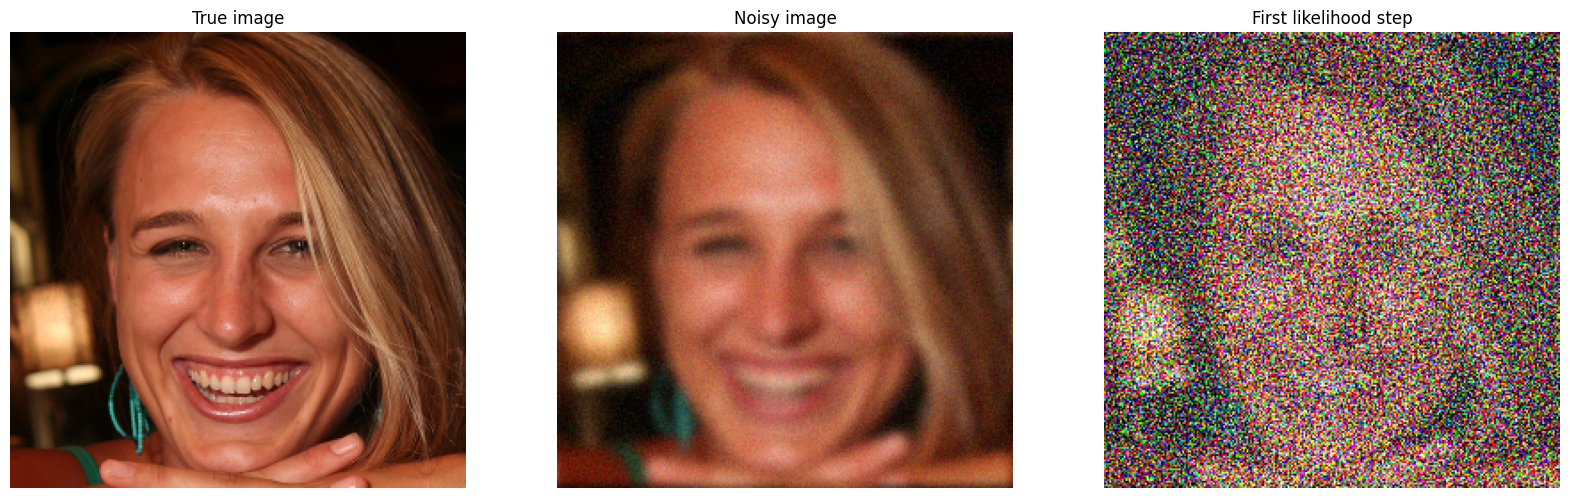

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(20, 20))

axes[0].imshow(clear_color(X))
axes[0].set_title('True image')
axes[0].axis('off');

axes[1].imshow(clear_color(Y))
axes[1].set_title('Noisy image')
axes[1].axis('off');

Z = torch.randn(N, device=device)
X_rec = operator.proximal_generator(Z, Y, sigma, rho=0.1)

axes[2].imshow(clear_color(X_rec));
axes[2].set_title('First likelihood step')
axes[2].axis('off');

In [25]:
N_bi = 20

gibbs = GibbsSampler(N=N, 
                     Y=Y, 
                     sigma=sigma, 
                     operator=operator, 
                     sampler=sampler, 
                     model=model, 
                     device=device, 
                     N_MC=23, 
                     N_bi=N_bi, 
                     rho=0.1, 
                     rho_decay_rate=0.8)

In [26]:
X_MC, Z_MC = gibbs.run()

100%|██████████| 23/23 [00:46<00:00,  2.01s/it]


In [8]:
from guided_diffusion.gaussian_diffusion import get_named_beta_schedule

betas = get_named_beta_schedule('linear', 1000)
alphas = np.cumsum(betas) / max(np.cumsum(betas))

def estimate_time(value, array=alphas):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

estimate sigma :  0.0005221040373686123
estimate time :  18


In [21]:
N_MC = 23
N_bi = 20
rho = 0.1
rho_decay_rate = 0.8

# Initialization
# define matrices to store the iterates
X_MC = torch.zeros(size = (3, N[1],N[2],N_MC+1), device=device)
Z_MC = torch.zeros(size = (3, N[1],N[2],N_MC+1), device=device)
# initialize the latter matrices
X_MC[:,:,:,0] = torch.randn(N, device=device)
Z_MC[:,:,:,0] = torch.randn(N, device=device)

# Gibbs sampling
for t in tqdm(range(N_MC)):
    # likelihood step
    X_MC[:,:,:,t+1] = operator.proximal_generator(Z_MC[:,:,:,t], Y, sigma, rho=rho)
    
    #est_sigma = estimate_noise(clear_color(X_MC[:,:,:,t+1]))
    rho_iter = rho * (rho_decay_rate**t)
    t_start = estimate_time(rho_iter)
    t_stop = compute_last_diff_step(t_start, N_bi)
        
    # prior step
    Z_MC[:,:,:,t+1] = sampler.diffuse_back(x=X_MC[:,:,:,t+1].unsqueeze(0), model=model, t_start=1000 - t_start, t_end=1000-t_stop).squeeze(0)

100%|██████████| 23/23 [00:43<00:00,  1.90s/it]


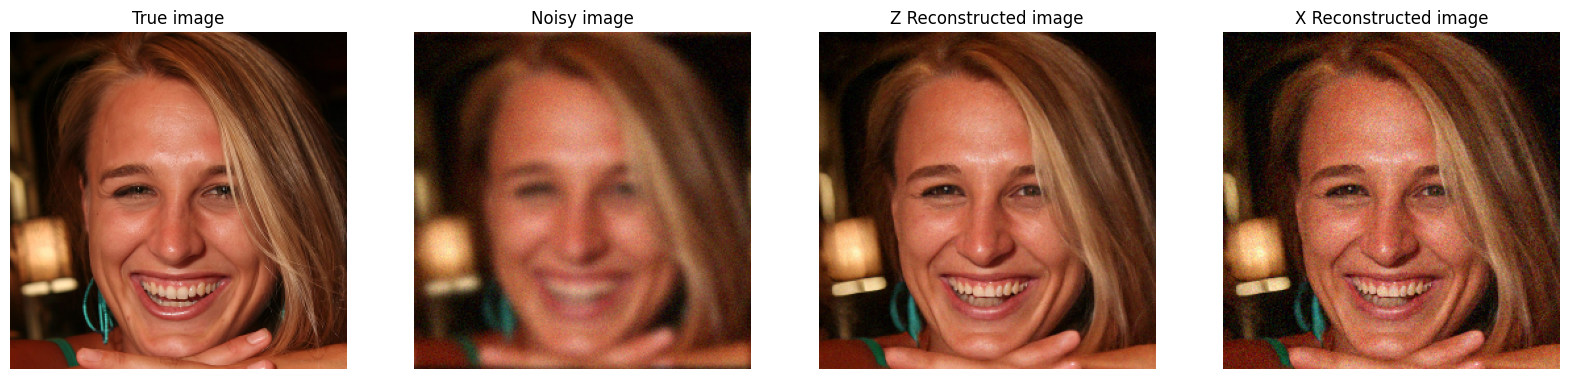

In [27]:
fig, axes = plt.subplots(1, 4, figsize=(20, 20))

axes[0].imshow(clear_color(X))
axes[0].set_title('True image')
axes[0].axis('off');

axes[1].imshow(clear_color(Y))
axes[1].set_title('Noisy image')
axes[1].axis('off');

axes[2].imshow(clear_color(torch.mean(Z_MC[:,:,:,N_bi:N_MC], axis=-1)));
axes[2].set_title('Z Reconstructed image')
axes[2].axis('off');

axes[3].imshow(clear_color(torch.mean(X_MC[:,:,:,N_bi:N_MC], axis=-1)));
axes[3].set_title('X Reconstructed image')
axes[3].axis('off');

In [ ]:
for i in range(N_MC):
    fig, axes = plt.subplots(1, 2, figsize=(20, 20))
    axes[0].imshow(clear_color(Z_MC[:,:,:,i]));
    axes[1].imshow(clear_color(X_MC[:,:,:,i]));
    plt.show();